<center> <h1>Predict the mouvement amplitude from the neural activity </h1> </center>

### Imports & Settings

First we need to import the modules to train the models, for more informations check the code. For the mouvement apmlitude I will use an array that I already computed because it take a while before getting the result (it depand on the length of the movie). I need also to specify the suite2p folder (where the results of suite2p where saved after using it.)

In [1]:
from mouse_brain.data_preprocess.data import  make_regression_loaders
from mouse_brain.models.regression import *
from mouse_brain.utils.regression_training import *
from mouse_brain.utils.evaluations import *
import matplotlib.pyplot as plt
from dtaidistance import dtw

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
suite_2p_folder = "/home/cossart/Activity_MVT/Data/2023-04-10_a/suite2p"
movement_amplitude_path = "/home/cossart/Activity_MVT/From_activity_to_mouvment/frame_diff.npy"
device = 'cuda' if torch.cuda.is_available else 'cpu'

### Data

This is how the movement amplitude looks like for this mouse.

Text(0.5, 1.0, 'Movement apmlitude')

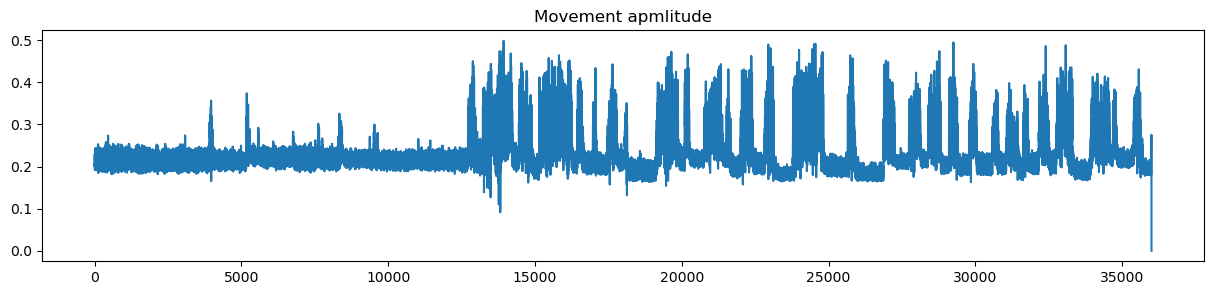

In [3]:
mvt_ampl = np.load(movement_amplitude_path).astype(np.float32)

plt.figure(figsize=(15, 3))

plt.plot(mvt_ampl)

plt.title("Movement apmlitude")

We see that the mouse is not moving so much at the begining and then it start moving a lot in the middle of the recording. Let's see how the neural activvity behave?

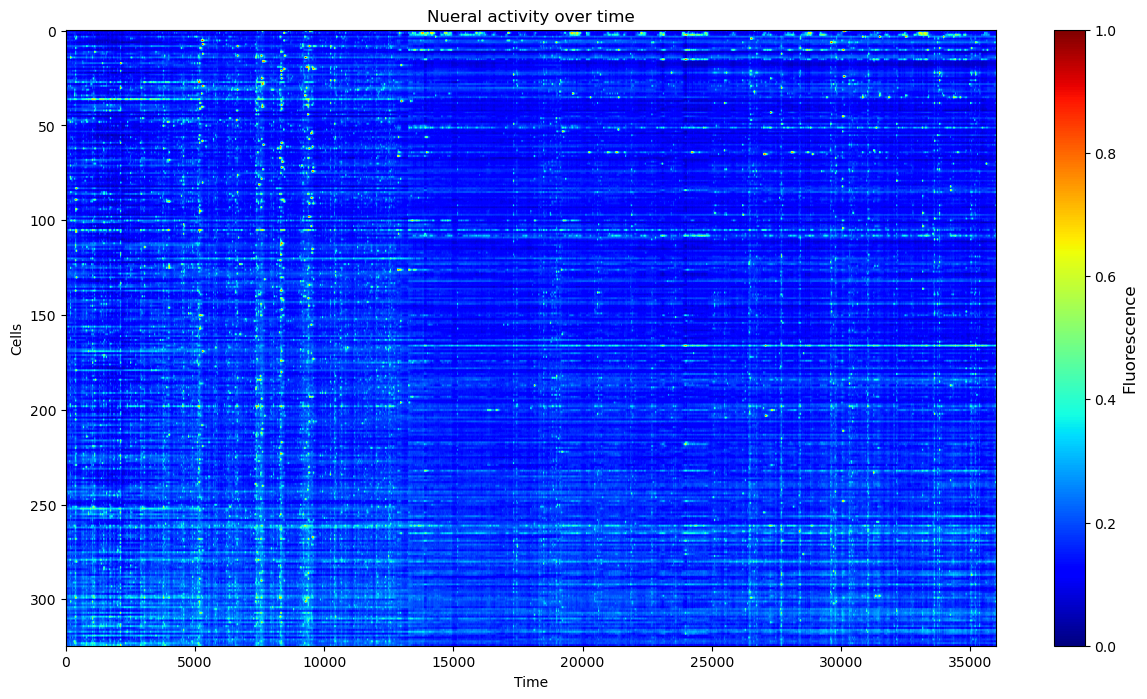

In [4]:
#The fluoresence activity
Fluo = np.load(os.path.join(suite_2p_folder, "plane0/F.npy"))

#The probability of each actitvity being a cell
is_cell = np.load(os.path.join(suite_2p_folder, "plane0/iscell.npy"))

#The probability threhold
probability = 0.95

#The selected cells using the threhold
selected_cells = Fluo[np.where(is_cell[:,1]>probability)]

# Normalize the data
selected_cells = (selected_cells - np.mean(selected_cells, axis=1)[:, np.newaxis])/np.std(selected_cells, axis=1)[:, np.newaxis]

selected_cells = (selected_cells - np.min(selected_cells, axis=1)[:, np.newaxis])/(np.max(selected_cells, axis=1)[:, np.newaxis] - np.min(selected_cells, axis=1)[:, np.newaxis])

mvt_ampl = (mvt_ampl - np.min(mvt_ampl))/(np.max(mvt_ampl) - np.min(mvt_ampl))

# Show the neural activity
import matplotlib.pyplot as plt
import numpy as np

# Display the image using imshow
plt.figure(figsize=(15, 8))
im = plt.imshow(selected_cells, cmap='jet', aspect="auto")

# Add titles to the X and Y axes
plt.xlabel('Time')
plt.ylabel('Cells')

# Add a color bar
colorbar = plt.colorbar(im)

# Set the title for the color bar
colorbar.set_label('Fluorescence', fontsize=12)

plt.title("Nueral activity over time")

# Show the plot
plt.show()

It seems that there is some neurala ctivity at the begining, not that much in the middle and it start a little bit at the end is there a correlation can we really predict the mouvement apmlitude from this neural activity? Let's split data and make loader for each part, and see if it is really possible.

In [5]:
train_loader, val_loader, test_loader = make_regression_loaders(suite_2p_folder, mvt_ampl, test_size=0.2, val_size=0.1, shift=0, discret_label=True)

- The number of ROI that are considered as cell with a probability higher than 0.95 is: 325
- The mouvement amplitude mean: 0.46662587 , std: 0.09864493


In [6]:
feature_size = 325

### Models

In [7]:
#Linear regression
linear_regression = LinearRegressor(feature_size, 1).to(device)

#Multi-layers perceptron
mlp = FCNN(feature_size, 1, 3).to(device)

#CNN
cnn = CNN(feature_size, 1, expected_latent_dim=10112).to(device)

#Multi-layers perceptron with combined loss
c_mlp = RegClassModel(feature_size, 10).to(device)

#CNN with combiner loss
c_cnn = ConvRegClassModel(feature_size, 1, expected_latent_dim=10112).to(device)

In [8]:
mse_criterion = nn.MSELoss().to(device)
bce_criterion = nn.BCEWithLogitsLoss().to(device)

### Training without combined loss

In [9]:
#Linear regression training
optimizer = optim.Adam(linear_regression.parameters())

linear_regression_histroy = train_model(linear_regression, optimizer, mse_criterion, train_loader, val_loader, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.010110992891601498  val loss: 0.006640038588860382  time: 1.4056034088134766 
Epoch: 2  train loss: 0.0060127528913258375  val loss: 0.0054814766303429175  time: 0.7362625598907471 
Epoch: 3  train loss: 0.005380359902620262  val loss: 0.005204404468208345  time: 0.7355835437774658 
Epoch: 4  train loss: 0.005143009184815826  val loss: 0.005199789294339199  time: 0.7379207611083984 
Epoch: 5  train loss: 0.0050391705933359905  val loss: 0.005144173631884364  time: 0.8159534931182861 
Epoch: 6  train loss: 0.004980707740335801  val loss: 0.005096484399271301  time: 0.8132975101470947 
Epoch: 7  train loss: 0.004942841660698138  val loss: 0.005062918828722711  time: 0.8251023292541504 
Epoch: 8  train loss: 0.004916661486742739  val loss: 0.005038999413955025  time: 0.711618185043335 
Epoch: 9  train loss: 0.004897878862830815  val loss: 0.005021416418862322  time: 0.8470025062561035 
Epoch: 10  train loss: 0.004884067988630546  val loss: 0.005008170246987397  tim

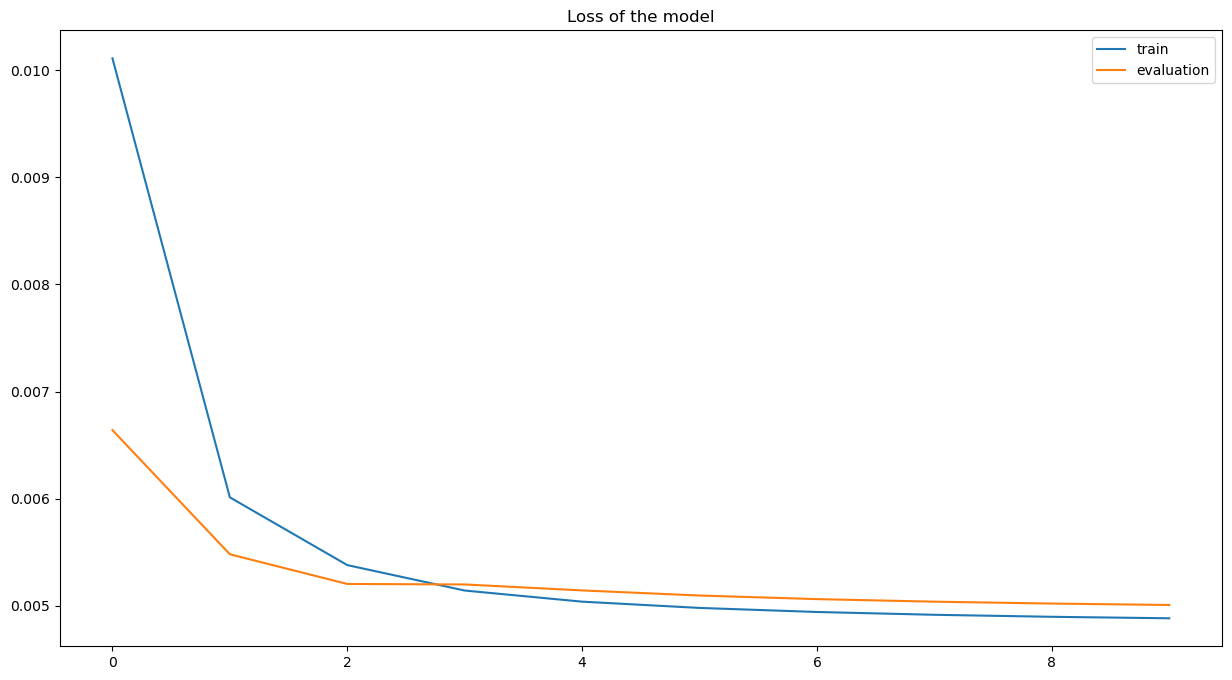

In [10]:
plt.figure(figsize=(15,8))
plt.plot(linear_regression_histroy["train"], label="train")
plt.plot(linear_regression_histroy["val"], label='evaluation')
plt.title("Loss of the model")
plt.legend()

In [11]:
#Multi perceptron training
optimizer = optim.Adam(mlp.parameters())

mlp_histroy = train_model(mlp, optimizer, mse_criterion, train_loader, val_loader, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.006617949075815786  val loss: 0.005128126310106988  time: 1.9067490100860596 
Epoch: 2  train loss: 0.0051715213845929375  val loss: 0.004936919275981684  time: 2.1828103065490723 
Epoch: 3  train loss: 0.005053690730696454  val loss: 0.004895379074797448  time: 1.9969215393066406 
Epoch: 4  train loss: 0.004993870937049497  val loss: 0.004840114823309705  time: 2.526353597640991 
Epoch: 5  train loss: 0.004955137927554197  val loss: 0.004869988771841033  time: 2.022325277328491 
Epoch: 6  train loss: 0.0049235946264012224  val loss: 0.004852616011501393  time: 1.9466853141784668 
Epoch: 7  train loss: 0.004900531993885322  val loss: 0.0049067706034596386  time: 2.016512393951416 
Epoch: 8  train loss: 0.004872964438504274  val loss: 0.004926664929371327  time: 2.2701642513275146 
Epoch: 9  train loss: 0.004858326819243927  val loss: 0.0048250910509119015  time: 2.3444950580596924 
Epoch: 10  train loss: 0.004841807422088684  val loss: 0.004790232107754693  time

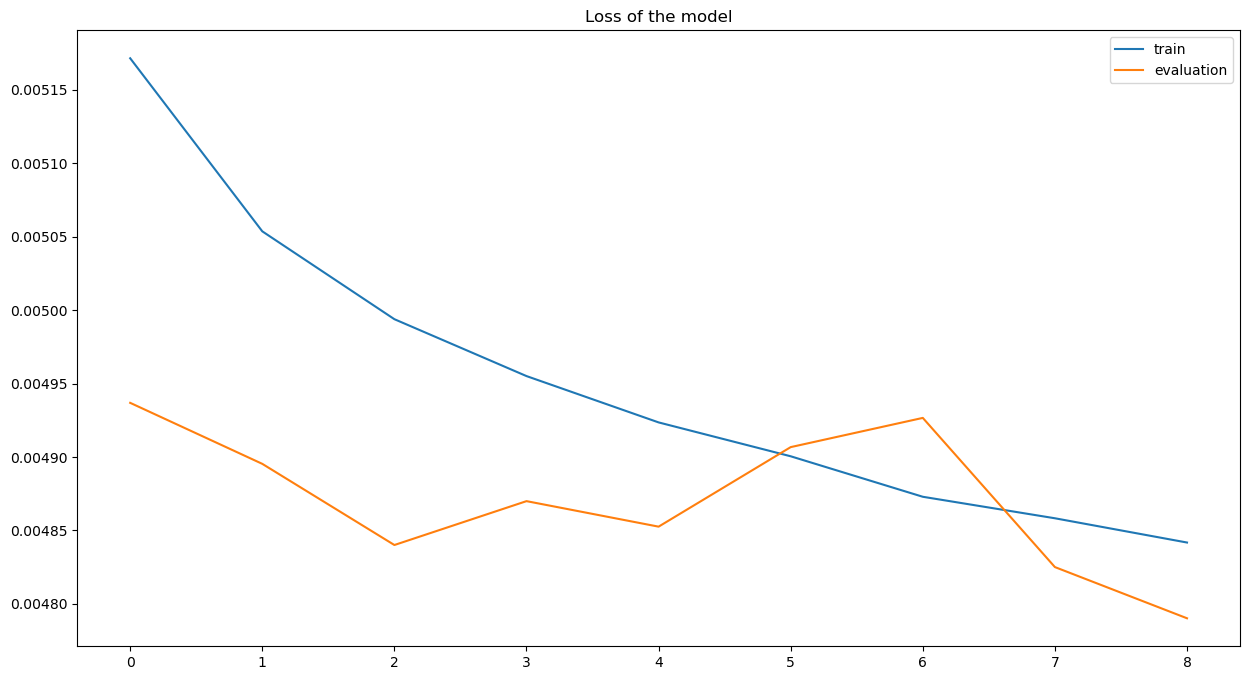

In [12]:
plt.figure(figsize=(15,8))
plt.plot(mlp_histroy["train"][1:], label="train")
plt.plot(mlp_histroy["val"][1:], label='evaluation')
plt.title("Loss of the model")
plt.legend()

In [13]:
#CNN training
optimizer = optim.Adam(cnn.parameters())

cnn_histroy = train_model(cnn, optimizer, mse_criterion, train_loader, val_loader, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.007303128957046547  val loss: 0.004930645178925867  time: 3.6313209533691406 
Epoch: 2  train loss: 0.005292218837494499  val loss: 0.004571249470852005  time: 2.9143691062927246 
Epoch: 3  train loss: 0.004963964451349606  val loss: 0.005238970554071582  time: 3.002277135848999 
Epoch: 4  train loss: 0.00488126413066588  val loss: 0.005329729015809587  time: 3.1291372776031494 
Epoch: 5  train loss: 0.004821143364185099  val loss: 0.005027269642192146  time: 2.927326202392578 
Epoch: 6  train loss: 0.004790933358011731  val loss: 0.004623593655802931  time: 2.7784652709960938 
Epoch: 7  train loss: 0.0047210990947588  val loss: 0.004537297804037937  time: 2.569035053253174 
Epoch: 8  train loss: 0.004642189801771841  val loss: 0.004540643404147381  time: 2.839118242263794 
Epoch: 9  train loss: 0.0046023239469063434  val loss: 0.004562258502119221  time: 2.464343547821045 
Epoch: 10  train loss: 0.00458385028911795  val loss: 0.004563691527841406  time: 2.52647

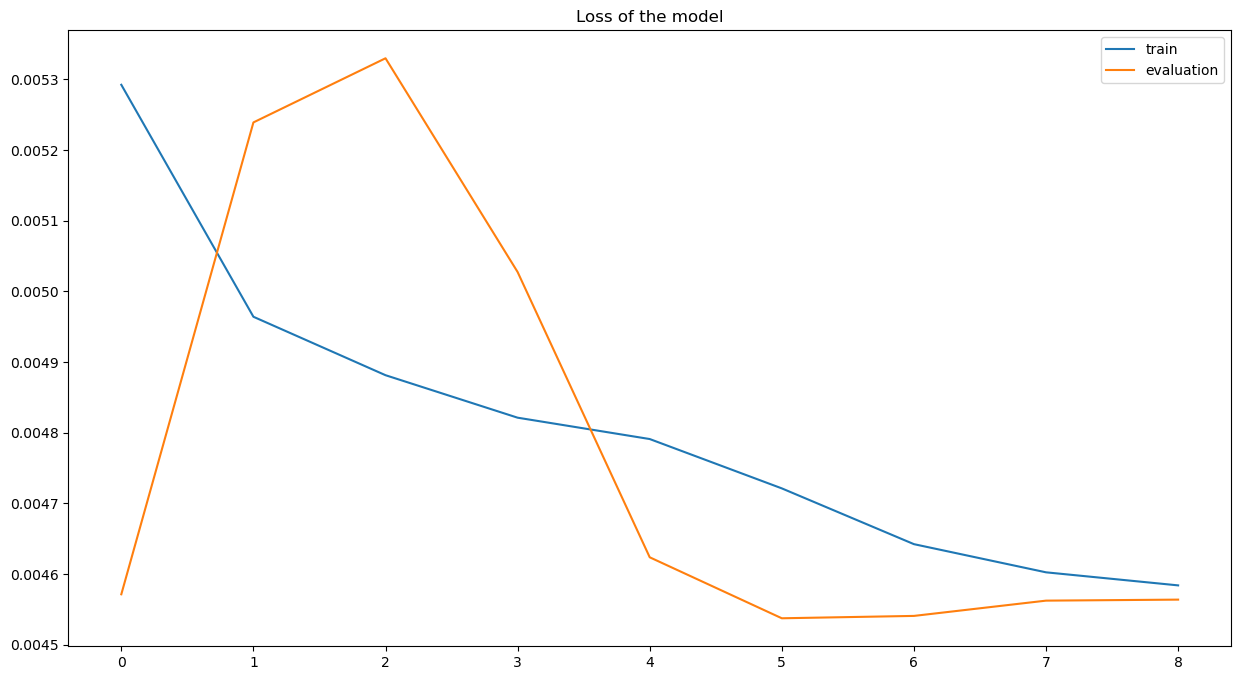

In [14]:
plt.figure(figsize=(15,8))
plt.plot(cnn_histroy["train"][1:], label="train")
plt.plot(cnn_histroy["val"][1:], label='evaluation')
plt.title("Loss of the model")
plt.legend()

### Training with combined loss

In [15]:
#Multi layer perceptron
optimizer = optim.Adam(c_mlp.parameters())

c_mlp_history = train_model_combined_loss(c_mlp, optimizer, mse_criterion, bce_criterion, 1, train_loader, val_loader, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.7010825902655504  val loss: 1.2948239164219961  time: 2.8801426887512207 
Epoch: 2  train loss: 0.693799349060957  val loss: 1.291837927367952  time: 2.2629966735839844 
Epoch: 3  train loss: 0.6933928237877031  val loss: 1.2912166565656662  time: 2.409102201461792 
Epoch: 4  train loss: 0.6932295363594368  val loss: 1.2933694339460797  time: 2.684014081954956 
Epoch: 5  train loss: 0.6931273897632885  val loss: 1.2950651066170797  time: 2.0504956245422363 
Epoch: 6  train loss: 0.693070679543099  val loss: 1.2961965617206361  time: 2.7274186611175537 
Epoch: 7  train loss: 0.6930284980270598  val loss: 1.2974854591819975  time: 2.5391767024993896 
Epoch: 8  train loss: 0.6929914507169078  val loss: 1.298807602789667  time: 2.096907377243042 
Epoch: 9  train loss: 0.6929692611602194  val loss: 1.3001020070579317  time: 2.8263800144195557 
Epoch: 10  train loss: 0.6929467789072922  val loss: 1.301007330417633  time: 2.038498878479004 


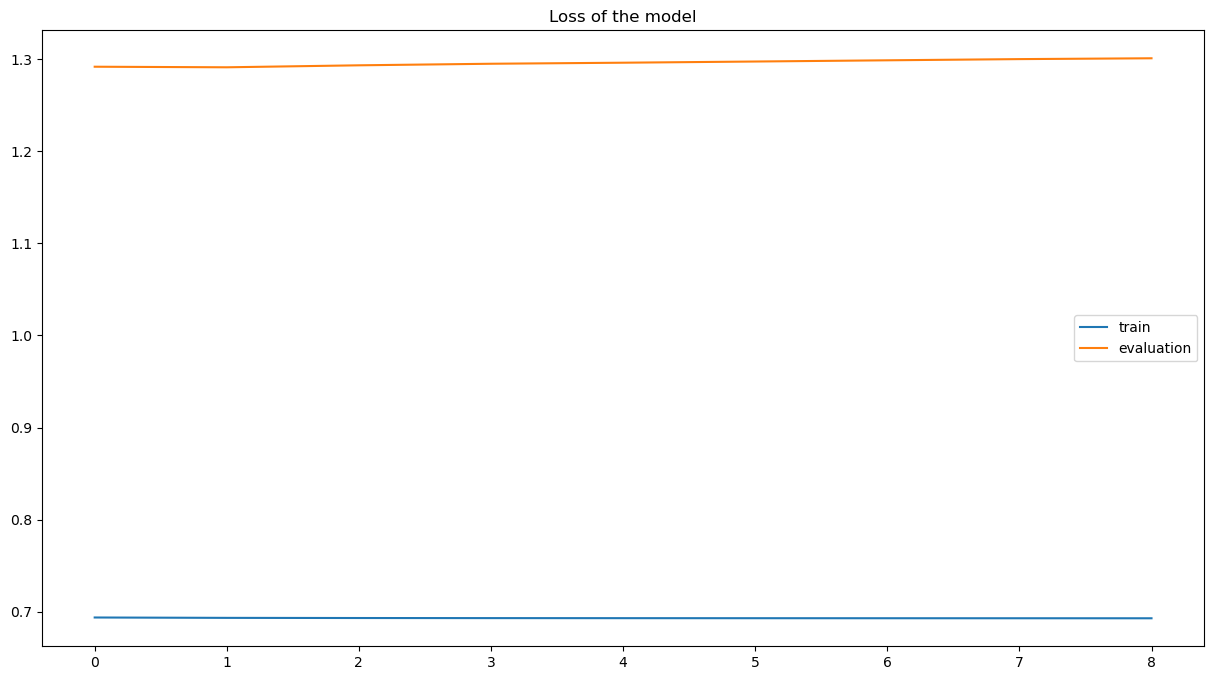

In [16]:
plt.figure(figsize=(15,8))
plt.plot(c_mlp_history["train"][1:], label="train")
plt.plot(c_mlp_history["val"][1:], label='evaluation')
plt.title("Loss of the model")
plt.legend()

In [17]:
#CNN training
optimizer = optim.Adam(c_cnn.parameters())

c_cnn_history = train_model_combined_loss(c_cnn, optimizer, mse_criterion, bce_criterion, 1, train_loader, val_loader, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6955394073240999  val loss: 1.3020032710499234  time: 3.1529598236083984 
Epoch: 2  train loss: 0.6931907994591672  val loss: 1.3017900834480922  time: 2.408585548400879 
Epoch: 3  train loss: 0.693079795886353  val loss: 1.3017754637532764  time: 2.9115283489227295 
Epoch: 4  train loss: 0.6929440975621126  val loss: 1.3020951234632068  time: 2.8470523357391357 
Epoch: 5  train loss: 0.6929208495190754  val loss: 1.30213377210829  time: 2.708310127258301 
Epoch: 6  train loss: 0.6928712258448347  val loss: 1.3020567695299785  time: 2.8909223079681396 
Epoch: 7  train loss: 0.6928072521364056  val loss: 1.3020129799842834  time: 2.727877140045166 
Epoch: 8  train loss: 0.6927298700463944  val loss: 1.3018982989920511  time: 3.1466190814971924 
Epoch: 9  train loss: 0.6927017453644011  val loss: 1.3018370336956449  time: 3.1205897331237793 
Epoch: 10  train loss: 0.6926717147015143  val loss: 1.3018756475713518  time: 3.1196751594543457 


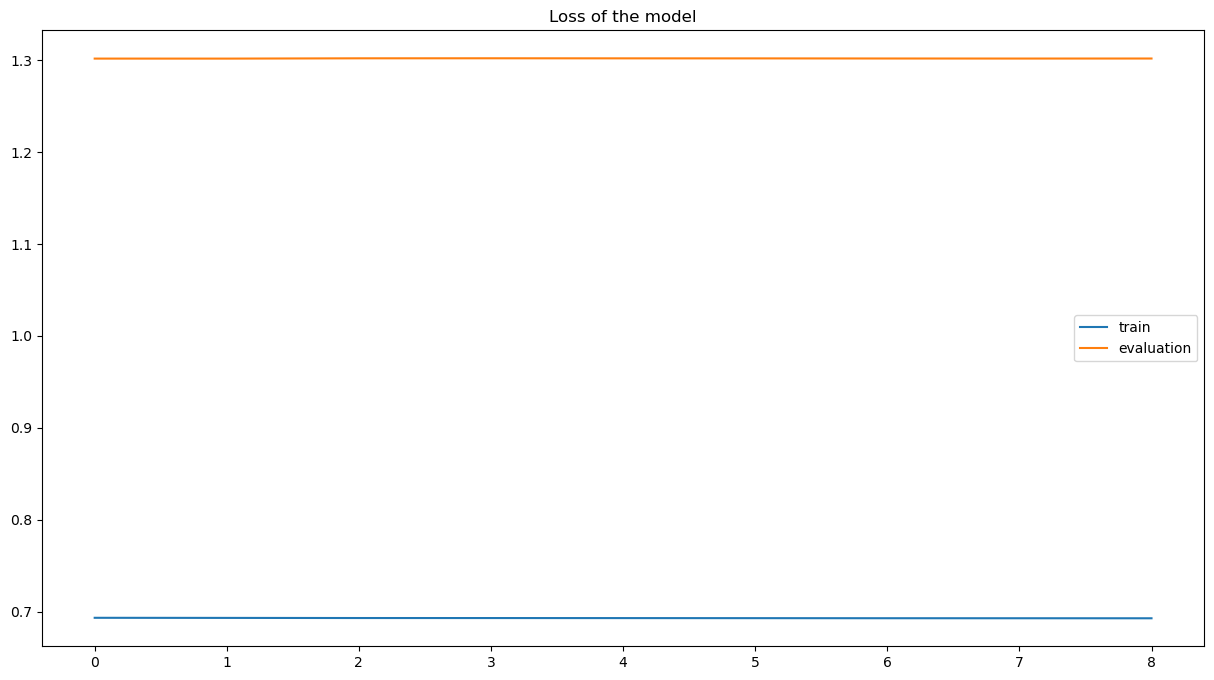

In [18]:
plt.figure(figsize=(15,8))
plt.plot(c_cnn_history["train"][1:], label="train")
plt.plot(c_cnn_history["val"][1:], label='evaluation')
plt.title("Loss of the model")
plt.legend()

### Evaluation and Results

In [19]:
#Evaluation in test

mse = test_model(linear_regression, mse_criterion, test_loader, device)

print("- Linear regression mean square error on test:", mse)


mse = test_model(mlp, mse_criterion, test_loader, device)

print("- Multi layer perceptron mean square error on test:", mse)


mse = test_model(cnn, mse_criterion, test_loader, device)

print("- CNN mean square error on test:", mse)


mse, bce = test_combined_loss_model(c_mlp, mse_criterion, bce_criterion, test_loader, device)

print("- Multi layer perceptron mean square error:", mse, ", binary cross entropy:", bce)


mse, bce = test_combined_loss_model(c_cnn, mse_criterion, bce_criterion, test_loader, device)

print("- CNN mean square error:", mse, ", binary cross entropy:", bce)

- Linear regression mean square error on test: 0.0048448187252506615
- Multi layer perceptron mean square error on test: 0.004638797436944312
- CNN mean square error on test: 0.004411460415253208
- Multi layer perceptron mean square error: 0.0049076755406955875 , binary cross entropy: 1.2979164589775933
- CNN mean square error: 0.004508078295427064 , binary cross entropy: 1.2992143731647068


In [20]:
X = torch.Tensor(selected_cells.T).to(torch.float32).to(device)

y_lin_reg = linear_regression(X).detach().cpu().numpy()

y_mlp =  mlp(X).detach().cpu().numpy()

y_cnn = cnn(X).detach().cpu().numpy()

y_c_mlp = c_mlp(X)[0].detach().cpu().numpy()

y_c_cnn = c_cnn(X)[0].detach().cpu().numpy()

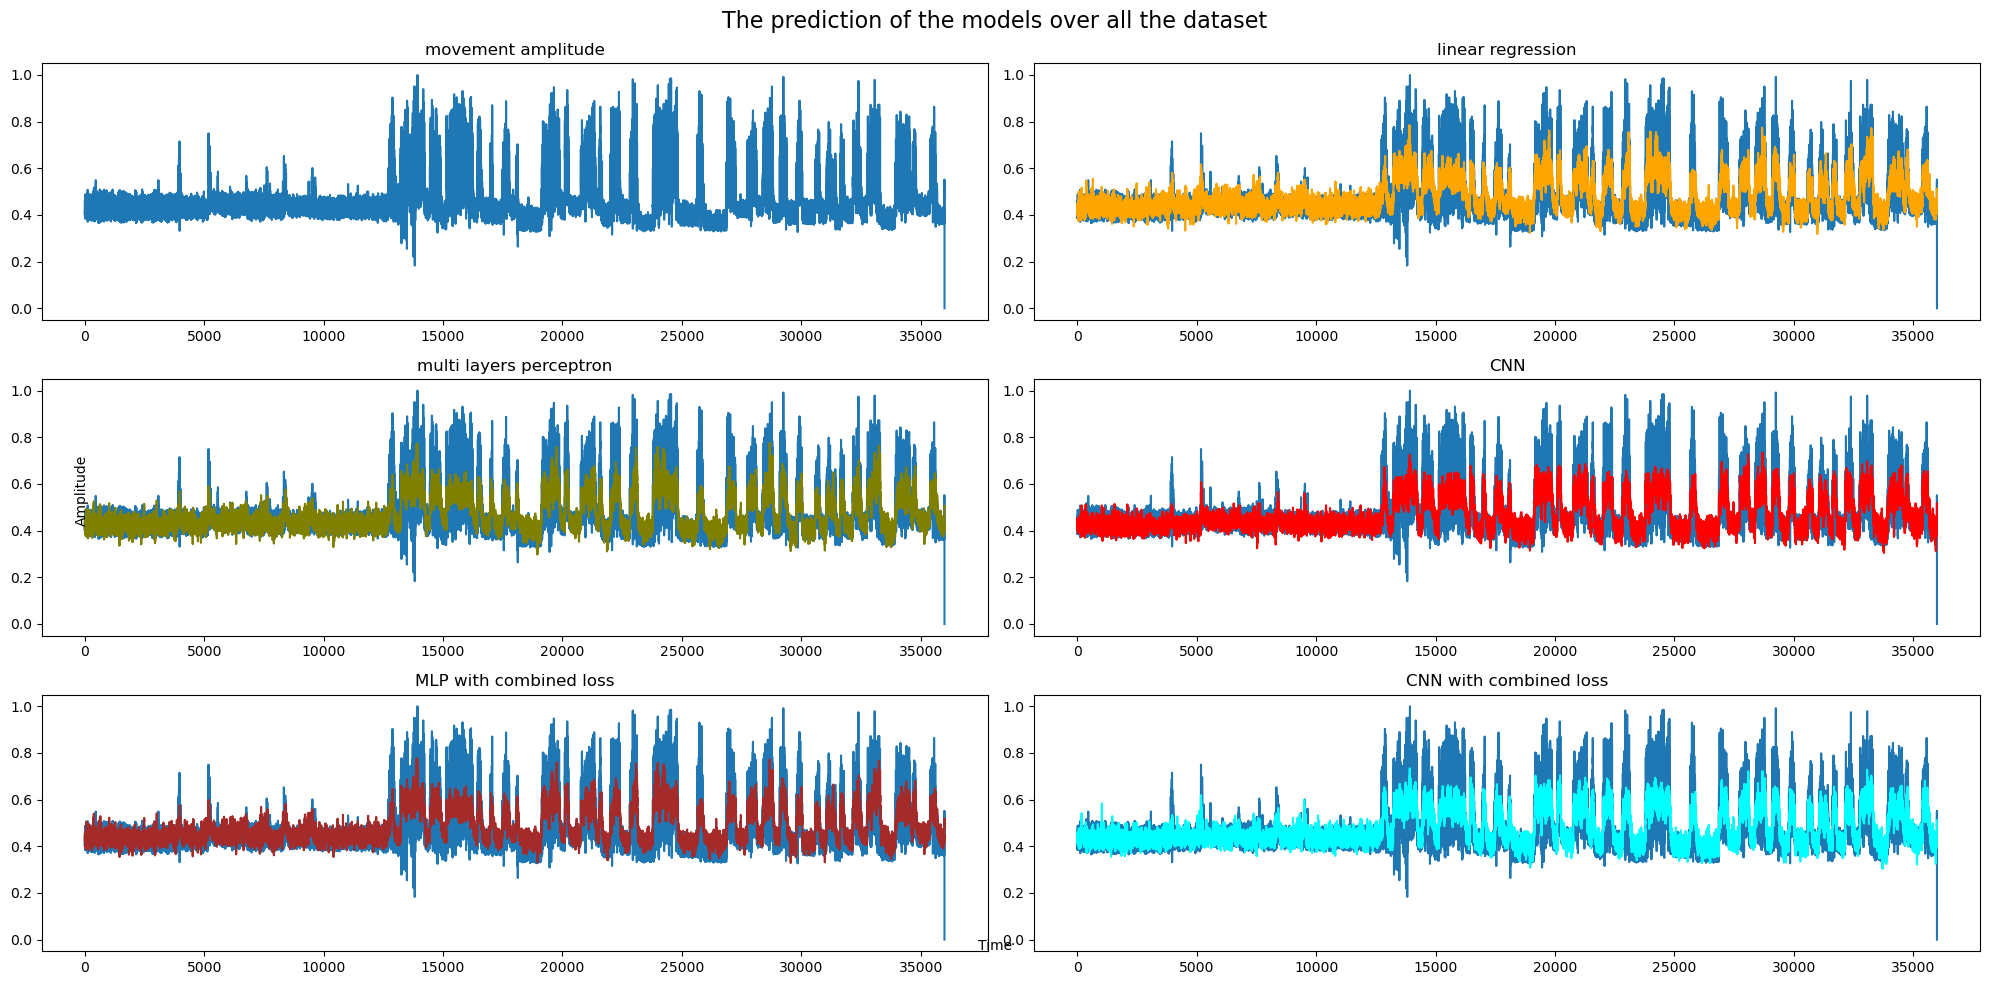

In [21]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(20, 10))

# Plot mvt_amplitude in the first subplot (upper left)
axs[0, 0].plot(mvt_ampl)
axs[0, 0].set_title('movement amplitude')

# Plot y_lin_reg in the second subplot (upper right)
axs[0, 1].plot(mvt_ampl)
axs[0, 1].plot(y_lin_reg, color='orange')
axs[0, 1].set_title('linear regression')

# Plot y_mlp in the third subplot (lower left)
axs[1, 0].plot(mvt_ampl)
axs[1, 0].plot(y_mlp, color='olive')
axs[1, 0].set_title('multi layers perceptron')

# Plot y_cnn in the fourth subplot (lower right)
axs[1, 1].plot(mvt_ampl)
axs[1, 1].plot(y_cnn, color='red')
axs[1, 1].set_title('CNN')


axs[2, 0].plot(mvt_ampl)
axs[2, 0].plot(y_c_mlp, color='brown')
axs[2, 0].set_title('MLP with combined loss')

# Plot y_cnn in the fourth subplot (lower right)
axs[2, 1].plot(mvt_ampl)
axs[2, 1].plot(y_c_cnn, color='cyan')
axs[2, 1].set_title('CNN with combined loss')


# Add a common x label and y label for the entire subplot
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Amplitude', va='center', rotation='vertical')

fig.suptitle('The prediction of the models over all the dataset', fontsize=16)

# Adjust layout
plt.tight_layout()

plt.savefig('models_preidctions.png', bbox_inches='tight')

# Show the plot
plt.show()

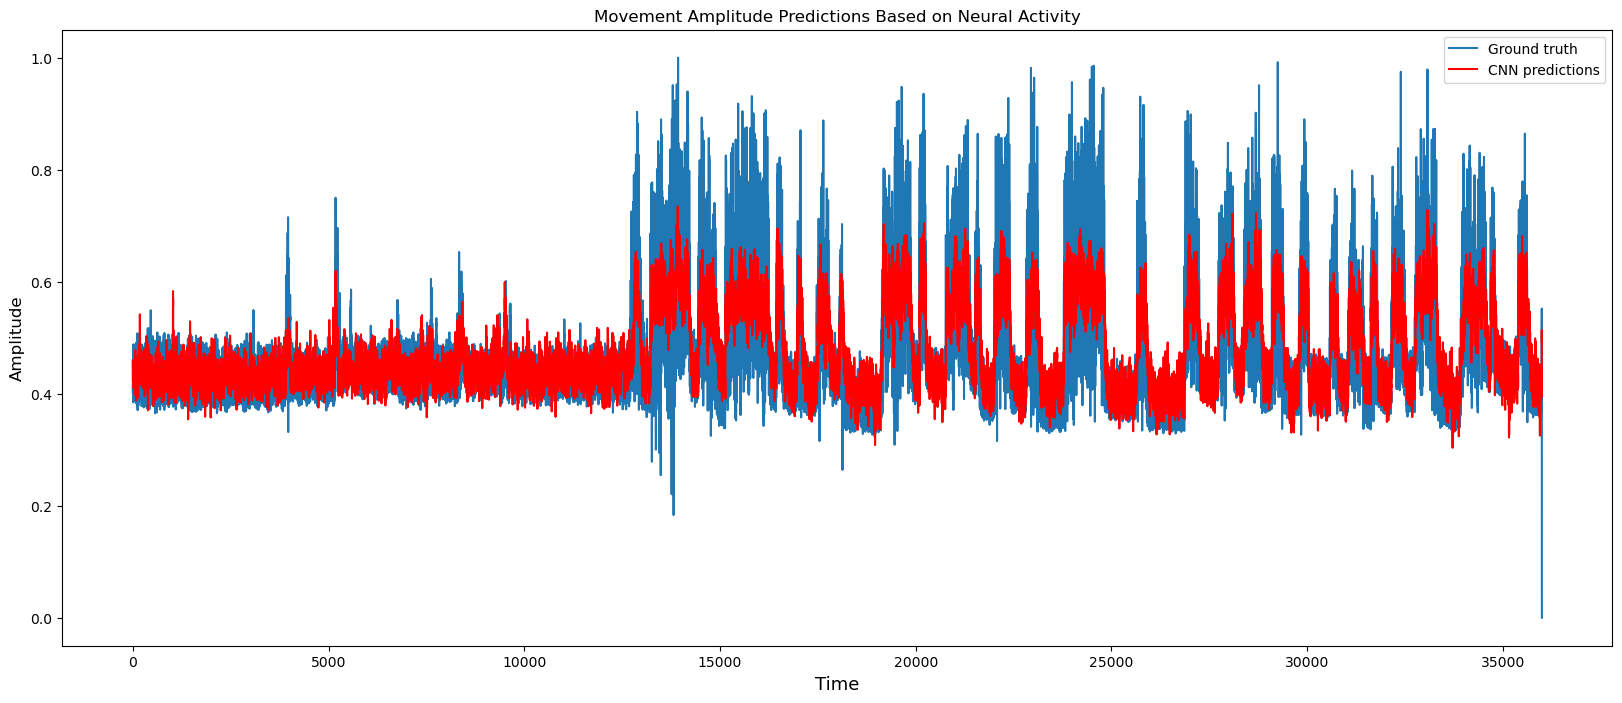

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(mvt_ampl, label='Ground truth')
plt.plot(y_c_cnn, label='CNN predictions', c='r')

plt.legend()
plt.title("Movement Amplitude Predictions Based on Neural Activity")
plt.xlabel("Time", fontsize=13)  # Adding x-axis label
plt.ylabel("Amplitude", fontsize=12)  # Adding y-axis label

plt.savefig('cnn_predictions.png', bbox_inches='tight')
plt.show()  # Don't forget to display the plot

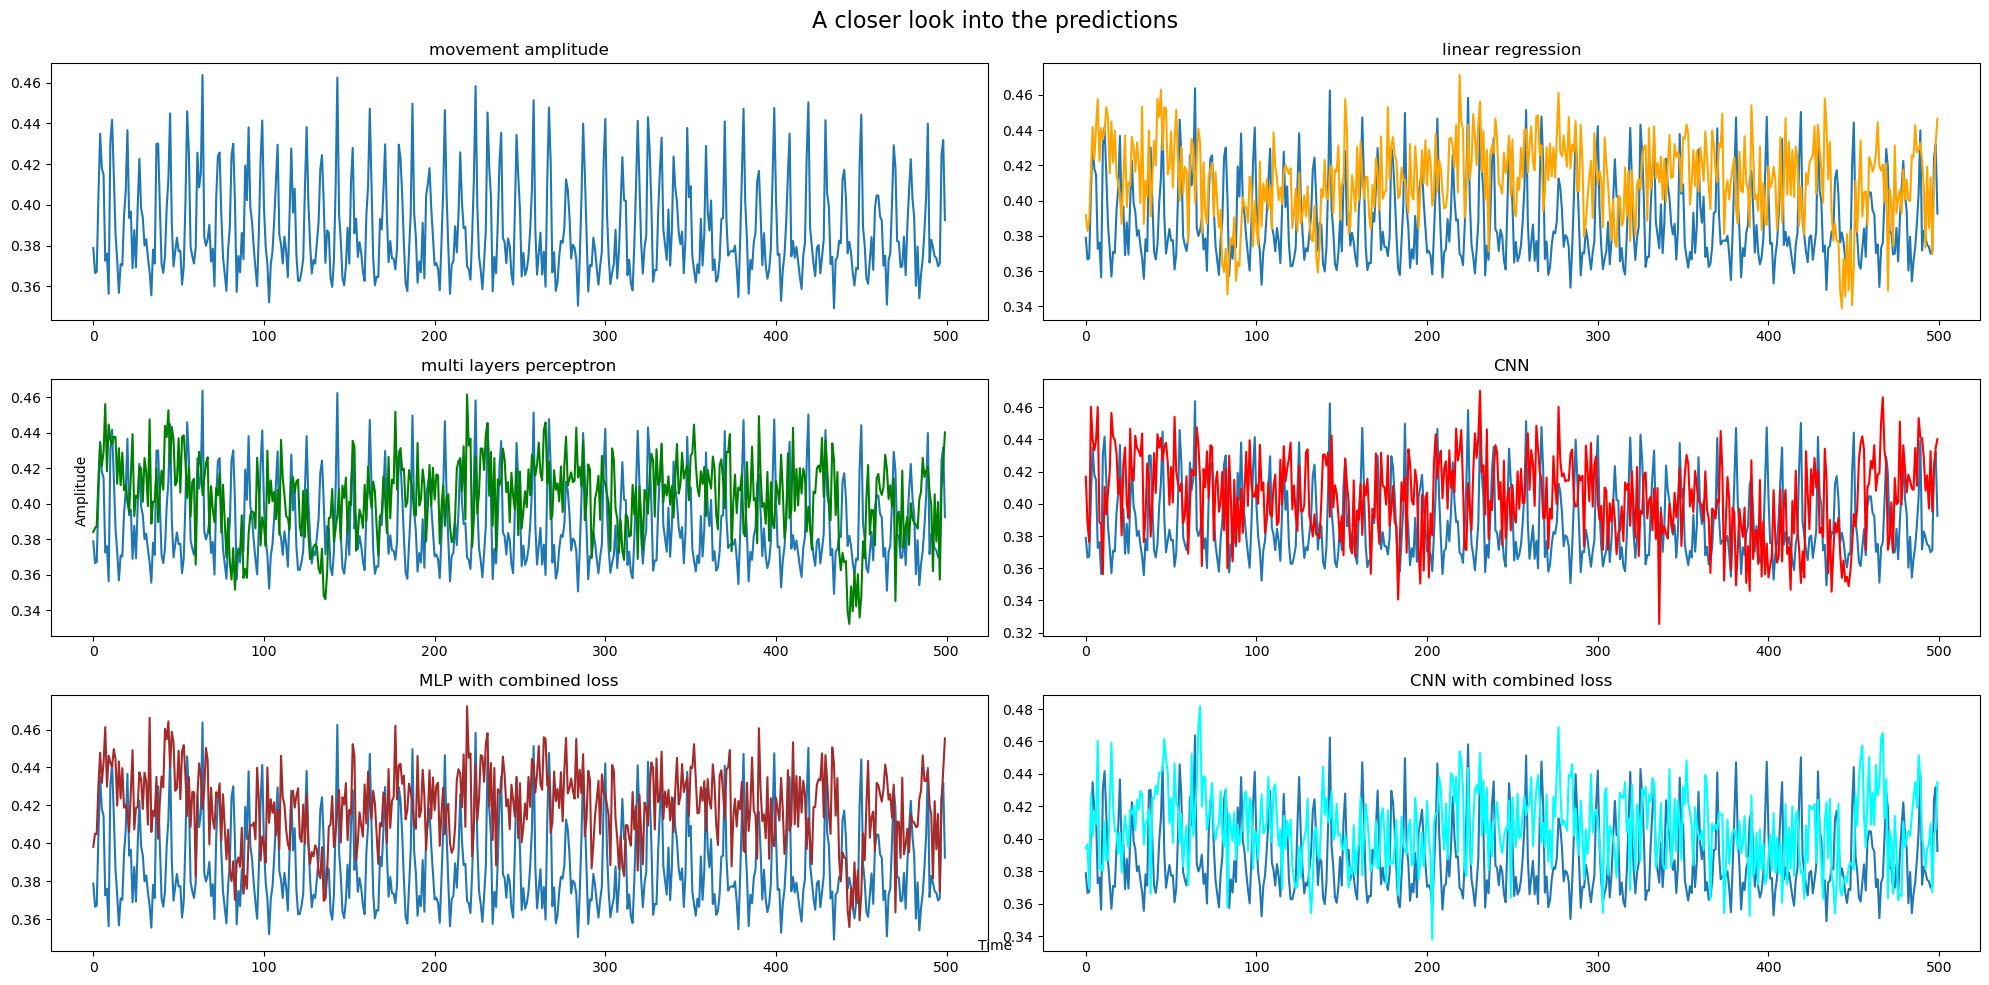

In [23]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(20, 10))

# Plot mvt_amplitude in the first subplot (upper left)
axs[0, 0].plot(mvt_ampl[25_000: 25_500])
axs[0, 0].set_title('movement amplitude')

# Plot y_lin_reg in the second subplot (upper right)
axs[0, 1].plot(mvt_ampl[25_000: 25_500])
axs[0, 1].plot(y_lin_reg[25_000: 25_500], color='orange')
axs[0, 1].set_title('linear regression')

# Plot y_mlp in the third subplot (lower left)
axs[1, 0].plot(mvt_ampl[25_000: 25_500])
axs[1, 0].plot(y_mlp[25_000: 25_500], color='green')
axs[1, 0].set_title('multi layers perceptron')

# Plot y_cnn in the fourth subplot (lower right)
axs[1, 1].plot(mvt_ampl[25_000: 25_500])
axs[1, 1].plot(y_cnn[25_000: 25_500], color='red')
axs[1, 1].set_title('CNN')


axs[2, 0].plot(mvt_ampl[25_000: 25_500])
axs[2, 0].plot(y_c_mlp[25_000: 25_500], color='brown')
axs[2, 0].set_title('MLP with combined loss')

# Plot y_cnn in the fourth subplot (lower right)
axs[2, 1].plot(mvt_ampl[25_000: 25_500])
axs[2, 1].plot(y_c_cnn[25_000: 25_500], color='cyan')
axs[2, 1].set_title('CNN with combined loss')


# Add a common x label and y label for the entire subplot
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Amplitude', va='center', rotation='vertical')

fig.suptitle('A closer look into the predictions', fontsize=16)

# Adjust layout
plt.tight_layout()


plt.savefig('closer_look.png', bbox_inches='tight')

In [24]:
#DYNAMIC TIME WARPING DISTANCE
d_linear_regression = dtw.distance_fast(mvt_ampl.astype(np.float64), y_lin_reg[:-2].squeeze().astype(np.float64), use_pruning=True)

d_mlp = dtw.distance_fast(mvt_ampl.astype(np.float64), y_mlp[:-2].squeeze().astype(np.float64), use_pruning=True)

d_cnn = dtw.distance_fast(mvt_ampl.astype(np.float64), y_cnn[:-2].squeeze().astype(np.float64), use_pruning=True)

d_c_mlp = dtw.distance_fast(mvt_ampl.astype(np.float64), y_c_mlp[:-2].squeeze().astype(np.float64), use_pruning=True)

d_c_cnn = dtw.distance_fast(mvt_ampl.astype(np.float64), y_c_cnn[:-2].squeeze().astype(np.float64), use_pruning=True)

In [25]:
print("Dynamic time warping distance of the linear regression:", d_linear_regression)
print("Dynamic time warping distance of the multi layer perceptron:", d_mlp)
print("Dynamic time warping distance of the CNN:", d_cnn)
print("Dynamic time warping distance of the multi layer perceptron with combined loss:", d_c_mlp)
print("Dynamic time warping distance of the CNN with combined loss:", d_c_cnn)

Dynamic time warping distance of the linear regression: 8.735754992679317
Dynamic time warping distance of the multi layer perceptron: 8.777078131920385
Dynamic time warping distance of the CNN: 8.52813381689441
Dynamic time warping distance of the multi layer perceptron with combined loss: 8.920894172343777
Dynamic time warping distance of the CNN with combined loss: 8.582762640459688


### Training with time shift

#### Positive shift

In [26]:
mse_pos_shift = []

bce_pos_shift = []

for i in range(0, 11):
    
    train_loader, val_loader, test_loader = make_regression_loaders(suite_2p_folder, mvt_ampl, test_size=0.3, val_size=0.1, shift=i, discret_label=True)

    #CNN
    c_cnn = ConvRegClassModel(feature_size, 1, expected_latent_dim=10112).to(device) 
    
    #CNN training
    optimizer = optim.Adam(c_cnn.parameters())

    c_cnn_history = train_model_combined_loss(c_cnn, optimizer, mse_criterion, bce_criterion, 1, train_loader, val_loader, 10, device)

    results = test_combined_loss_model(c_cnn, mse_criterion, bce_criterion, test_loader, device)

    mse_pos_shift.append(results[0])

    bce_pos_shift.append(results[1])

- The number of ROI that are considered as cell with a probability higher than 0.95 is: 325
- The mouvement amplitude mean: 0.46662587 , std: 0.09864493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.695212427135379  val loss: 1.3000923884766442  time: 3.4141652584075928 
Epoch: 2  train loss: 0.6930885240943826  val loss: 1.300508086170469  time: 3.6861929893493652 
Epoch: 3  train loss: 0.6929902780755317  val loss: 1.3004756548574992  time: 3.6283860206604004 
Epoch: 4  train loss: 0.692918780149249  val loss: 1.3013645155089242  time: 3.480821371078491 
Epoch: 5  train loss: 0.6928928757917344  val loss: 1.3014125632388251  time: 3.271350383758545 
Epoch: 6  train loss: 0.6928203252295355  val loss: 1.3015520232064384  time: 3.505227565765381 
Epoch: 7  train loss: 0.6927575499917118  val loss: 1.3018473535776138  time: 3.40800404548645 
Epoch: 8  train loss: 0.6926948960773942  val loss: 1.301823432956423  time: 3.012861728668213 
Epoch: 9  train loss: 0.6926750982279342  val loss: 1.3026714154652186  time: 3.5719969272613525 
Epoch: 10  train loss: 0.692660892562684  val loss: 1.3027927939380919  time: 3.4544146060943604 
- The number of ROI that are c

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6992891750426767  val loss: 1.3076490291527338  time: 2.871448516845703 
Epoch: 2  train loss: 0.6983328360815165  val loss: 1.308305282677923  time: 3.5871808528900146 
Epoch: 3  train loss: 0.6981822070938829  val loss: 1.3084410322563989  time: 3.3850088119506836 
Epoch: 4  train loss: 0.6981102948624636  val loss: 1.3087638744286128  time: 3.597945213317871 
Epoch: 5  train loss: 0.6980910400414044  val loss: 1.3090146226542336  time: 3.4112062454223633 
Epoch: 6  train loss: 0.6981143383830176  val loss: 1.3088798416512353  time: 3.1817829608917236 
Epoch: 7  train loss: 0.6981088339387964  val loss: 1.3087887444666453  time: 3.669421672821045 
Epoch: 8  train loss: 0.6980713525377875  val loss: 1.3087937384843826  time: 3.3814828395843506 
Epoch: 9  train loss: 0.6980363378583327  val loss: 1.308928091611181  time: 3.447483777999878 
Epoch: 10  train loss: 0.6980213969336038  val loss: 1.3088720057691847  time: 3.4560446739196777 
- The number of ROI that 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6999387772802116  val loss: 1.2990862280130386  time: 3.328441858291626 
Epoch: 2  train loss: 0.6988190776003984  val loss: 1.3018648837293898  time: 3.571039915084839 
Epoch: 3  train loss: 0.6986878193904725  val loss: 1.3029807806015015  time: 3.511129140853882 
Epoch: 4  train loss: 0.6985480726822336  val loss: 1.3047166168689728  time: 3.4784841537475586 
Epoch: 5  train loss: 0.6985302686203388  val loss: 1.304798709494727  time: 3.570333480834961 
Epoch: 6  train loss: 0.6984449244456271  val loss: 1.30412030007158  time: 3.5956294536590576 
Epoch: 7  train loss: 0.6983646003969044  val loss: 1.3034313746861048  time: 3.2875351905822754 
Epoch: 8  train loss: 0.6983050308806509  val loss: 1.3037681835038322  time: 3.3729746341705322 
Epoch: 9  train loss: 0.6982603750482588  val loss: 1.3038279456751687  time: 3.4412591457366943 
Epoch: 10  train loss: 0.698228380201946  val loss: 1.3036625598158156  time: 2.9072048664093018 
- The number of ROI that ar

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6990218021046741  val loss: 1.3176519870758057  time: 2.9928410053253174 
Epoch: 2  train loss: 0.698271173816098  val loss: 1.316743450505393  time: 3.074976682662964 
Epoch: 3  train loss: 0.6981124749450371  val loss: 1.3148116213934762  time: 3.6826565265655518 
Epoch: 4  train loss: 0.6979872404634546  val loss: 1.3138539152485984  time: 3.0418288707733154 
Epoch: 5  train loss: 0.6979284917511361  val loss: 1.3130644985607691  time: 3.059432029724121 
Epoch: 6  train loss: 0.697878982490602  val loss: 1.3124266862869263  time: 3.5024943351745605 
Epoch: 7  train loss: 0.6978280750010544  val loss: 1.3119282637323653  time: 3.554523468017578 
Epoch: 8  train loss: 0.6977965162525723  val loss: 1.3115783631801605  time: 3.1167707443237305 
Epoch: 9  train loss: 0.697762821006905  val loss: 1.3113475846392768  time: 3.071843385696411 
Epoch: 10  train loss: 0.6977490775419289  val loss: 1.3113200111048562  time: 3.116126298904419 
- The number of ROI that are

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6992902671981801  val loss: 1.3089854977347635  time: 3.2379963397979736 
Epoch: 2  train loss: 0.6981429287714002  val loss: 1.3091624650088223  time: 3.5135223865509033 
Epoch: 3  train loss: 0.6980376883548409  val loss: 1.3091101711446589  time: 3.44140887260437 
Epoch: 4  train loss: 0.6978360598279216  val loss: 1.309225648099726  time: 3.266406774520874 
Epoch: 5  train loss: 0.6978065541463855  val loss: 1.3092520995573564  time: 3.393289804458618 
Epoch: 6  train loss: 0.6978056268184605  val loss: 1.309304410761053  time: 3.6280627250671387 
Epoch: 7  train loss: 0.697753249053903  val loss: 1.3092928236181085  time: 3.5243473052978516 
Epoch: 8  train loss: 0.6977228646714235  val loss: 1.3093055616725575  time: 3.373152256011963 
Epoch: 9  train loss: 0.6976948853729529  val loss: 1.309317818554965  time: 3.5505847930908203 
Epoch: 10  train loss: 0.697665452062677  val loss: 1.3093543182719838  time: 3.7831709384918213 
- The number of ROI that are 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6993969443062318  val loss: 1.31539024439725  time: 2.6953582763671875 
Epoch: 2  train loss: 0.6984601474556396  val loss: 1.3122688965363936  time: 2.9662961959838867 
Epoch: 3  train loss: 0.698246071071937  val loss: 1.311633331125433  time: 3.115382194519043 
Epoch: 4  train loss: 0.6981577818748245  val loss: 1.3116635604338212  time: 3.411903142929077 
Epoch: 5  train loss: 0.698130129710714  val loss: 1.3116948127746582  time: 3.5754315853118896 
Epoch: 6  train loss: 0.6981117030933479  val loss: 1.3117743817242709  time: 3.591632604598999 
Epoch: 7  train loss: 0.6980904400104715  val loss: 1.31184683713046  time: 2.9816877841949463 
Epoch: 8  train loss: 0.6980597306891646  val loss: 1.311961952122775  time: 3.1487369537353516 
Epoch: 9  train loss: 0.6980273908189667  val loss: 1.3124096155166627  time: 3.4526312351226807 
Epoch: 10  train loss: 0.6980125249489267  val loss: 1.3121804649179631  time: 3.0640616416931152 
- The number of ROI that are c

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6996002764851464  val loss: 1.315320244702426  time: 3.452489137649536 
Epoch: 2  train loss: 0.6981093064662054  val loss: 1.315052953633395  time: 3.4034581184387207 
Epoch: 3  train loss: 0.6979307911243152  val loss: 1.315331016887318  time: 3.203974485397339 
Epoch: 4  train loss: 0.6979201919873121  val loss: 1.3155290300195868  time: 3.541220188140869 
Epoch: 5  train loss: 0.6978753508357038  val loss: 1.3153489112854004  time: 3.7288684844970703 
Epoch: 6  train loss: 0.6979345008425953  val loss: 1.3153182528235696  time: 3.179795980453491 
Epoch: 7  train loss: 0.6978401725484111  val loss: 1.3154954238371415  time: 3.1298437118530273 
Epoch: 8  train loss: 0.6977886136362041  val loss: 1.3162514686584472  time: 3.3017826080322266 
Epoch: 9  train loss: 0.6977055968073835  val loss: 1.3168932329524647  time: 3.6320252418518066 
Epoch: 10  train loss: 0.6976886695761635  val loss: 1.3160128571770409  time: 3.6204028129577637 
- The number of ROI that a

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.7004239642929088  val loss: 1.3107721068642355  time: 3.2879300117492676 
Epoch: 2  train loss: 0.69835666826282  val loss: 1.310430804165927  time: 3.379940986633301 
Epoch: 3  train loss: 0.6982583162891913  val loss: 1.3108058972792191  time: 3.388967514038086 
Epoch: 4  train loss: 0.6981965248939285  val loss: 1.3109497568824076  time: 3.053739070892334 
Epoch: 5  train loss: 0.6981393320010759  val loss: 1.3111996672370216  time: 3.4476687908172607 
Epoch: 6  train loss: 0.6980950170454517  val loss: 1.311691858551719  time: 3.109663724899292 
Epoch: 7  train loss: 0.6980261769333771  val loss: 1.3117973327636718  time: 2.2768006324768066 
Epoch: 8  train loss: 0.6979759163127914  val loss: 1.3115997726267035  time: 3.460817575454712 
Epoch: 9  train loss: 0.6979416896669146  val loss: 1.3112604813142257  time: 3.1645638942718506 
Epoch: 10  train loss: 0.6978734222635891  val loss: 1.3110570474104448  time: 3.3044843673706055 
- The number of ROI that are

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6997326502695903  val loss: 1.3052866675636985  time: 3.281590223312378 
Epoch: 2  train loss: 0.698361429397276  val loss: 1.3068117553537542  time: 3.4491610527038574 
Epoch: 3  train loss: 0.6981715693317689  val loss: 1.3076130216771906  time: 1.9586601257324219 
Epoch: 4  train loss: 0.6981039462766088  val loss: 1.307643554427407  time: 1.6093482971191406 
Epoch: 5  train loss: 0.6980809279060624  val loss: 1.3082794666290283  time: 1.466334342956543 
Epoch: 6  train loss: 0.6979976955897811  val loss: 1.3087680621580644  time: 1.5214807987213135 
Epoch: 7  train loss: 0.697982366950255  val loss: 1.3088761741464787  time: 1.5929546356201172 
Epoch: 8  train loss: 0.6979248837592007  val loss: 1.3089480031620373  time: 1.447178602218628 
Epoch: 9  train loss: 0.6978909931924463  val loss: 1.308917598290877  time: 1.5171678066253662 
Epoch: 10  train loss: 0.6978901759664163  val loss: 1.308452838117426  time: 1.444342851638794 
- The number of ROI that are

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.699274565643373  val loss: 1.311054736917669  time: 3.4381585121154785 
Epoch: 2  train loss: 0.6983992185794315  val loss: 1.3116873589428988  time: 3.544222831726074 
Epoch: 3  train loss: 0.6984004764569895  val loss: 1.312225580215454  time: 3.573298215866089 
Epoch: 4  train loss: 0.6980550758347505  val loss: 1.3124898086894643  time: 3.5869429111480713 
Epoch: 5  train loss: 0.6980306844431576  val loss: 1.3126937389373778  time: 3.587080478668213 
Epoch: 6  train loss: 0.6980022129388005  val loss: 1.312752079963684  time: 3.53055477142334 
Epoch: 7  train loss: 0.6979708868354599  val loss: 1.3128003228794445  time: 3.3308098316192627 
Epoch: 8  train loss: 0.6979466735259573  val loss: 1.3127580425956034  time: 3.534872531890869 
Epoch: 9  train loss: 0.6979203134734504  val loss: 1.312803892655806  time: 3.5114645957946777 
Epoch: 10  train loss: 0.6979028672833723  val loss: 1.3129181905226275  time: 3.488494873046875 
- The number of ROI that are co

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.7001264984490442  val loss: 1.3065070737491955  time: 3.4212729930877686 
Epoch: 2  train loss: 0.6982834703121029  val loss: 1.3074358636682684  time: 3.5410850048065186 
Epoch: 3  train loss: 0.6982140834214258  val loss: 1.3081356785514138  time: 3.6506261825561523 
Epoch: 4  train loss: 0.6981885170187455  val loss: 1.3090157985687256  time: 3.1688780784606934 
Epoch: 5  train loss: 0.6981727782168675  val loss: 1.309506596218456  time: 3.11234450340271 
Epoch: 6  train loss: 0.6981115975503713  val loss: 1.3088279095563022  time: 3.380286931991577 
Epoch: 7  train loss: 0.6980711927667993  val loss: 1.3092968745665117  time: 3.688025951385498 
Epoch: 8  train loss: 0.6980389956730962  val loss: 1.3093140103600243  time: 3.4583795070648193 
Epoch: 9  train loss: 0.6979792171000131  val loss: 1.308887132731351  time: 3.497257947921753 
Epoch: 10  train loss: 0.6979483198272726  val loss: 1.3088955705816097  time: 3.4891085624694824 


### Negative shift

In [27]:
mse_neg_shift = []

bce_neg_shift = []

for i in range(1, 11):
    
    train_loader, val_loader, test_loader = make_regression_loaders(suite_2p_folder, mvt_ampl, test_size=0.3, val_size=0.1, shift=-i, discret_label=True)

    #CNN
    c_cnn = ConvRegClassModel(feature_size, 1, expected_latent_dim=10112).to(device)     
    
    #CNN training
    optimizer = optim.Adam(c_cnn.parameters())
    

    c_cnn_history = train_model_combined_loss(c_cnn, optimizer, mse_criterion, bce_criterion, 1, train_loader, val_loader, 10, device)
    

    results = test_combined_loss_model(c_cnn, mse_criterion, bce_criterion, test_loader, device)

    mse_neg_shift.append(results[0])

    bce_neg_shift.append(results[1])

- The number of ROI that are considered as cell with a probability higher than 0.95 is: 325
- The mouvement amplitude mean: 0.46662587 , std: 0.09864493


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6994093283299372  val loss: 1.3058581437383379  time: 3.264948606491089 
Epoch: 2  train loss: 0.6983882786469765  val loss: 1.3062112522976739  time: 3.6639838218688965 
Epoch: 3  train loss: 0.6982084888390597  val loss: 1.3066053433077676  time: 3.3608434200286865 
Epoch: 4  train loss: 0.6981398764118492  val loss: 1.3066436627081461  time: 3.4628007411956787 
Epoch: 5  train loss: 0.6980583589691745  val loss: 1.306779214314052  time: 3.217323064804077 
Epoch: 6  train loss: 0.6980573953743033  val loss: 1.3069796711206436  time: 3.4102184772491455 
Epoch: 7  train loss: 0.6980276090711721  val loss: 1.3070508135216576  time: 3.1707756519317627 
Epoch: 8  train loss: 0.6980064901616043  val loss: 1.3069156557321548  time: 3.4395241737365723 
Epoch: 9  train loss: 0.6979804461844784  val loss: 1.3070723967892783  time: 3.5009026527404785 
Epoch: 10  train loss: 0.6980018732817729  val loss: 1.3070185482501984  time: 3.615412473678589 
- The number of ROI tha

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6995865860382173  val loss: 1.3079888692923956  time: 2.944373607635498 
Epoch: 2  train loss: 0.6984229741610414  val loss: 1.31204611488751  time: 3.3341939449310303 
Epoch: 3  train loss: 0.698243555398137  val loss: 1.3125776882682527  time: 3.55090594291687 
Epoch: 4  train loss: 0.6980409664476714  val loss: 1.3098899445363454  time: 3.534186601638794 
Epoch: 5  train loss: 0.6979855263216922  val loss: 1.3091169042246682  time: 3.323859930038452 
Epoch: 6  train loss: 0.6979459206209013  val loss: 1.3088801567043578  time: 3.597958564758301 
Epoch: 7  train loss: 0.6978938825946875  val loss: 1.3091652010168349  time: 3.3334810733795166 
Epoch: 8  train loss: 0.6978967425605285  val loss: 1.3087666928768158  time: 3.214118719100952 
Epoch: 9  train loss: 0.6978547988614476  val loss: 1.3092810277427946  time: 2.9990122318267822 
Epoch: 10  train loss: 0.6978846045177923  val loss: 1.3084415729556764  time: 3.1927404403686523 
- The number of ROI that are 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6994145589017933  val loss: 1.3079881540366582  time: 2.7891502380371094 
Epoch: 2  train loss: 0.6984576897601639  val loss: 1.3087924548557825  time: 3.139233350753784 
Epoch: 3  train loss: 0.6983227074390219  val loss: 1.3088739344051905  time: 3.56296443939209 
Epoch: 4  train loss: 0.6982516025943938  val loss: 1.3090133922440665  time: 3.261352300643921 
Epoch: 5  train loss: 0.6982144285679514  val loss: 1.3089713113648551  time: 3.441211462020874 
Epoch: 6  train loss: 0.6981679581685086  val loss: 1.3090101650782995  time: 3.632432222366333 
Epoch: 7  train loss: 0.6981267053303581  val loss: 1.3090982799019133  time: 3.3330438137054443 
Epoch: 8  train loss: 0.6980849267028039  val loss: 1.3091027183192117  time: 3.7300662994384766 
Epoch: 9  train loss: 0.6980649534546824  val loss: 1.3091483286448888  time: 2.7056186199188232 
Epoch: 10  train loss: 0.6980383825497283  val loss: 1.3091390005179815  time: 3.423569917678833 
- The number of ROI that a

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6994707153406182  val loss: 1.3119728955355558  time: 3.3016316890716553 
Epoch: 2  train loss: 0.6982714315878906  val loss: 1.3131960717114535  time: 3.294459342956543 
Epoch: 3  train loss: 0.6982076741338265  val loss: 1.313389288295399  time: 3.172776222229004 
Epoch: 4  train loss: 0.6981578614832109  val loss: 1.3132966019890524  time: 3.2144298553466797 
Epoch: 5  train loss: 0.6981131785725831  val loss: 1.3126966281370682  time: 3.3872742652893066 
Epoch: 6  train loss: 0.6980824850265847  val loss: 1.3122052062641492  time: 3.1385645866394043 
Epoch: 7  train loss: 0.698039024621045  val loss: 1.3113220951773903  time: 3.5723230838775635 
Epoch: 8  train loss: 0.6980377077080543  val loss: 1.31128464828838  time: 3.41522479057312 
Epoch: 9  train loss: 0.6980042955234627  val loss: 1.3110570430755615  time: 3.2715396881103516 
Epoch: 10  train loss: 0.6980923574422911  val loss: 1.3106127348813144  time: 3.586587429046631 
- The number of ROI that are

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6995605447445202  val loss: 1.3057986541227862  time: 3.3702120780944824 
Epoch: 2  train loss: 0.6983593842993003  val loss: 1.305615175854076  time: 3.2222816944122314 
Epoch: 3  train loss: 0.6986133429395877  val loss: 1.3056471846320412  time: 3.152876377105713 
Epoch: 4  train loss: 0.6981512064985819  val loss: 1.3059677817604758  time: 3.36914324760437 
Epoch: 5  train loss: 0.6980987708370162  val loss: 1.3059073621576482  time: 3.6886045932769775 
Epoch: 6  train loss: 0.6981020490924789  val loss: 1.3093356154181741  time: 3.3944926261901855 
Epoch: 7  train loss: 0.6979292635215093  val loss: 1.306070375442505  time: 3.477351188659668 
Epoch: 8  train loss: 0.697844801463014  val loss: 1.306108331680298  time: 3.145763874053955 
Epoch: 9  train loss: 0.6978290202998204  val loss: 1.3061705047434027  time: 3.6518101692199707 
Epoch: 10  train loss: 0.6978297980875793  val loss: 1.3062768372622404  time: 3.3614518642425537 
- The number of ROI that are

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6997110117506363  val loss: 1.3076778000051326  time: 3.0857343673706055 
Epoch: 2  train loss: 0.6983840356582184  val loss: 1.3082907980138605  time: 3.3169121742248535 
Epoch: 3  train loss: 0.698289962533714  val loss: 1.3094671401110562  time: 3.5495688915252686 
Epoch: 4  train loss: 0.698220495556419  val loss: 1.3101268378171054  time: 3.375356435775757 
Epoch: 5  train loss: 0.698155541455762  val loss: 1.3103844425894997  time: 3.2720096111297607 
Epoch: 6  train loss: 0.6981341446080279  val loss: 1.3103714075955477  time: 3.5528485774993896 
Epoch: 7  train loss: 0.6980902724181484  val loss: 1.3105123801664873  time: 3.216031789779663 
Epoch: 8  train loss: 0.6980403018518164  val loss: 1.3104017886248502  time: 2.6431846618652344 
Epoch: 9  train loss: 0.6979913761150626  val loss: 1.3107242800972678  time: 2.9823715686798096 
Epoch: 10  train loss: 0.6979729918633444  val loss: 1.3108144976876  time: 3.3093364238739014 
- The number of ROI that ar

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6994682246308372  val loss: 1.3083446394313465  time: 3.3100008964538574 
Epoch: 2  train loss: 0.6981579524758406  val loss: 1.3092982790686867  time: 3.449232578277588 
Epoch: 3  train loss: 0.6980126125262834  val loss: 1.3094615849581632  time: 3.391460657119751 
Epoch: 4  train loss: 0.6979354932233386  val loss: 1.309363434531472  time: 3.222337245941162 
Epoch: 5  train loss: 0.6978900426081388  val loss: 1.3093127424066717  time: 3.6517906188964844 
Epoch: 6  train loss: 0.6978622518002092  val loss: 1.3095088178461247  time: 3.7134311199188232 
Epoch: 7  train loss: 0.6978757970980375  val loss: 1.309687987240878  time: 3.4758243560791016 
Epoch: 8  train loss: 0.6978606600390612  val loss: 1.3101664087989113  time: 3.4735233783721924 
Epoch: 9  train loss: 0.6978765030024322  val loss: 1.3099819486791437  time: 3.398467540740967 
Epoch: 10  train loss: 0.6978740835254872  val loss: 1.3100087317553433  time: 3.5119166374206543 
- The number of ROI that 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6999661398779646  val loss: 1.3101563583720814  time: 1.3341100215911865 
Epoch: 2  train loss: 0.6982891279060551  val loss: 1.310148024559021  time: 1.5618233680725098 
Epoch: 3  train loss: 0.6981679412547758  val loss: 1.3103827996687456  time: 3.1896822452545166 
Epoch: 4  train loss: 0.6981363009463228  val loss: 1.3104857553135265  time: 2.673722743988037 
Epoch: 5  train loss: 0.6980175553207345  val loss: 1.310589634288441  time: 1.4317562580108643 
Epoch: 6  train loss: 0.6979913975824926  val loss: 1.310673637823625  time: 1.4138526916503906 
Epoch: 7  train loss: 0.6979843864336833  val loss: 1.3106785427440297  time: 1.4243435859680176 
Epoch: 8  train loss: 0.6979700496056883  val loss: 1.3108386343175715  time: 1.4315757751464844 
Epoch: 9  train loss: 0.6979303590109697  val loss: 1.3106654578989203  time: 1.4441313743591309 
Epoch: 10  train loss: 0.6979422609119753  val loss: 1.3106418067758734  time: 1.4178743362426758 
- The number of ROI tha

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6993125008691057  val loss: 1.3076836347579956  time: 3.457387924194336 
Epoch: 2  train loss: 0.698265289788682  val loss: 1.3083870996128428  time: 3.2559750080108643 
Epoch: 3  train loss: 0.698114762446077  val loss: 1.3087289441715588  time: 3.4526705741882324 
Epoch: 4  train loss: 0.6980728986806466  val loss: 1.3089906107295644  time: 3.429415464401245 
Epoch: 5  train loss: 0.6980523207665791  val loss: 1.3086624513972889  time: 3.7528913021087646 
Epoch: 6  train loss: 0.6980056878164065  val loss: 1.3085207744078202  time: 3.4859097003936768 
Epoch: 7  train loss: 0.6979654471187929  val loss: 1.3083912936123934  time: 3.5171942710876465 
Epoch: 8  train loss: 0.6979423133608101  val loss: 1.3082443128932606  time: 3.5221221446990967 
Epoch: 9  train loss: 0.6979431166818002  val loss: 1.3081207145344127  time: 3.204335927963257 
Epoch: 10  train loss: 0.6978904032447003  val loss: 1.3083471449938688  time: 3.618222713470459 
- The number of ROI that 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.6997552927725953  val loss: 1.3080920826305042  time: 3.3601651191711426 
Epoch: 2  train loss: 0.6983556109862249  val loss: 1.3080046502026645  time: 3.459398031234741 
Epoch: 3  train loss: 0.6981507334552828  val loss: 1.3084450786763973  time: 3.3854072093963623 
Epoch: 4  train loss: 0.6981117461548477  val loss: 1.3086531509052624  time: 3.3846280574798584 
Epoch: 5  train loss: 0.6980809648343123  val loss: 1.3088428714058615  time: 3.512474298477173 
Epoch: 6  train loss: 0.6980639801976459  val loss: 1.3088989647951994  time: 3.2582550048828125 
Epoch: 7  train loss: 0.6980584537396666  val loss: 1.308797619559548  time: 3.4664554595947266 
Epoch: 8  train loss: 0.6980209929532692  val loss: 1.308804737437855  time: 3.6960043907165527 
Epoch: 9  train loss: 0.6980103261646677  val loss: 1.3088332891464234  time: 3.6784493923187256 
Epoch: 10  train loss: 0.6980093636962234  val loss: 1.3088981194929643  time: 3.3902907371520996 


### MSE and BSE based in shift

In [30]:
time_shifts = list(range(-10, 0)) + list(range(0, 11))

# Reverse the bce_neg_shift array
bce_neg_shift = bce_neg_shift[::-1]

bce_values = bce_neg_shift + bce_pos_shift

# Reverse the mse_neg_shift array
mse_neg_shift = mse_neg_shift[::-1]

mse_values = mse_neg_shift + mse_pos_shift

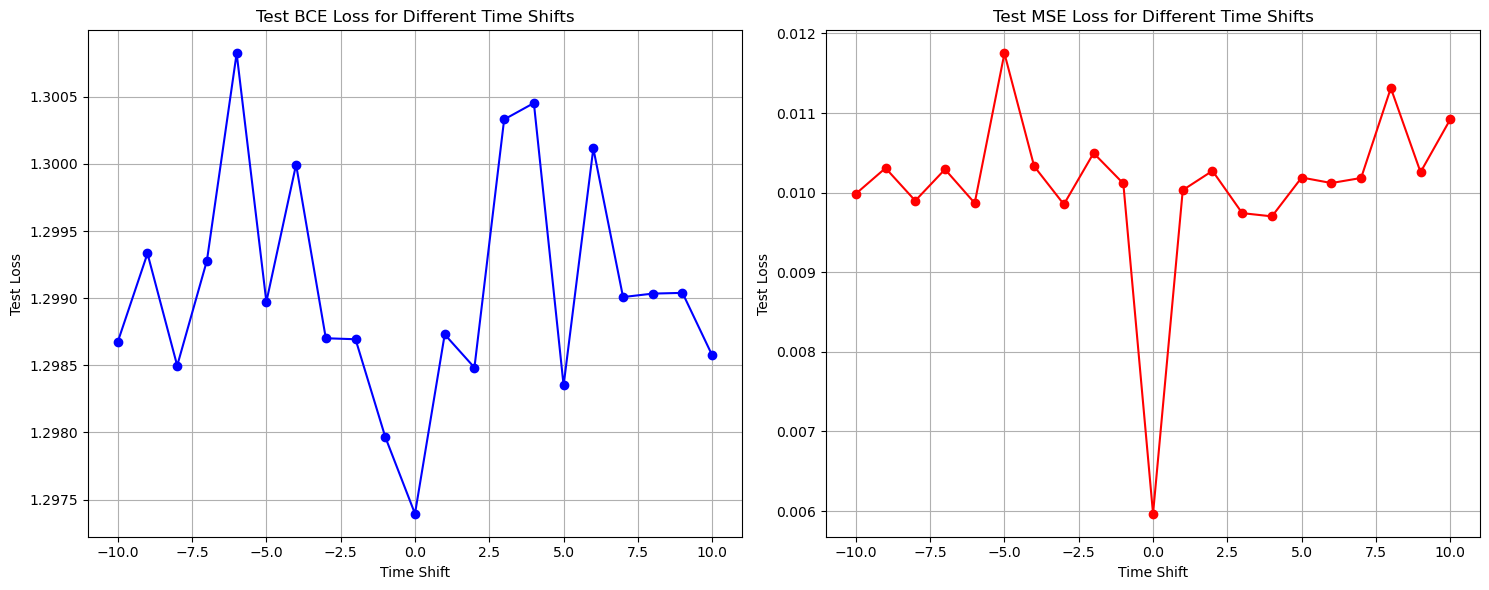

In [32]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot BCE Loss
ax1.plot(time_shifts, bce_values, marker='o', linestyle='-', color='b')
ax1.set_xlabel('Time Shift')
ax1.set_ylabel('Test Loss')
ax1.set_title('Test BCE Loss for Different Time Shifts')
ax1.grid(True)

# Plot MSE Loss
ax2.plot(time_shifts, mse_values, marker='o', linestyle='-', color='r')
ax2.set_xlabel('Time Shift')
ax2.set_ylabel('Test Loss')
ax2.set_title('Test MSE Loss for Different Time Shifts')
ax2.grid(True)

# Adjust layout and display
plt.tight_layout()

plt.savefig('time_shift_performances.png', bbox_inches='tight')

plt.show()